In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from math import factorial
from scipy.linalg import solveh_banded, solve_toeplitz, toeplitz, solve
np.set_printoptions(precision=3, linewidth=200)
from scipy.special import roots_legendre, roots_chebyt
from scipy.integrate import quad
from scipy.misc import derivative
from scipy.stats import qmc

In [3]:
def get_points(a, b, n, mode):
    if mode == 'uniform':
        points = np.linspace(a, b, n)
    elif mode == 'random':
        points = np.concatenate(([a], np.sort(np.random.rand(n - 2) * (b - a) + a), [b]))
    elif mode == 'chebyshev':
        points = (np.polynomial.chebyshev.chebpts1(n) + 1) / 2 * (b - a) + a
    else:
        print(f'incorrect mode {mode}')
        points = 0
    return np.array(points)

In [4]:
def plot(f1, f2, a, b, name):
    #a = a - 1
    #b = b + 1
    plot_points = get_points(a, b, int(100 * (b - a)), 'uniform')
    plt.plot(plot_points, f1(plot_points), label='function')
    plt.plot(plot_points, f2(plot_points), label='pade')
    plt.title(name)
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
def exp_maclaurin(n):
    a = np.zeros(n)
    for i in range(n):
        a[i] = 1 / factorial(i)
    return np.array(a)

exp_maclaurin(5)

array([1.   , 1.   , 0.5  , 0.167, 0.042])

In [6]:
def sin_maclaurin(n):
    a = np.zeros(n)
    for i in range(n):
        if i % 2 == 0:
            continue
        else:
            c = 1 if i % 4 == 1 else -1
            a[i] = c / factorial(i) 
    return np.array(a)

sin_maclaurin(5)

array([ 0.   ,  1.   ,  0.   , -0.167,  0.   ])

In [7]:
def cos_maclaurin(n):
    a = np.zeros(n)
    for i in range(n):
        if i % 2 == 1:
            continue
        else:
            c = -1 if i % 4 == 2 else 1
            a[i] = c / factorial(i) 
    return np.array(a)

cos_maclaurin(5)

array([ 1.   ,  0.   , -0.5  ,  0.   ,  0.042])

In [8]:
def pade_approx(m, n, f, a, left, right, verbose=False):
    c = a[m: m + n]
    r = np.flip(a[m - n + 1 : m + 1])
    b = a[m + 1: m + 1 + n]
    if verbose:
        print('c\n', c)
        print('r\n', r)
        print('b\n', b)
        print('\nmatrix\n', toeplitz(c, r))
    q = solve(toeplitz(c, r), b, check_finite=False)
    c = a[0: m + 1]
    r = np.concatenate((a[0:1], np.zeros(m)))
    if verbose:
        print('\nq\n', q)
        print('c\n', c)
        print('r\n', r)
        
    mat = toeplitz(c, r)
    if verbose:
        print('\nmat\n', mat)
    q = np.concatenate(([1], q))
    mat_q = q[:m + 1]
    p = mat @ mat_q
    p = Polynomial(p)
    q = Polynomial(q)
    if verbose:
        print('p', p)
        print('q', q)
    def rational(x):
        return p(x) / q(x)
    plot(f, rational, left, right, f'pade ({m}, {n}) approximation')

[ 0.000e+00  1.000e+00  0.000e+00 -1.667e-01  0.000e+00  8.333e-03  0.000e+00 -1.984e-04  0.000e+00]
c
 [-0.167  0.     0.008  0.   ]
r
 [-0.167  0.     1.     0.   ]
b
 [ 0.     0.008  0.    -0.   ]

matrix
 [[-0.167  0.     1.     0.   ]
 [ 0.    -0.167  0.     1.   ]
 [ 0.008  0.    -0.167  0.   ]
 [ 0.     0.008  0.    -0.167]]

q
 [-0.    -0.061 -0.    -0.002]
c
 [ 0.     1.     0.    -0.167]
r
 [0. 0. 0. 0.]

mat
 [[ 0.     0.     0.     0.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.     1.     0.     0.   ]
 [-0.167  0.     1.     0.   ]]
p 0.0 + 1.0·x + 0.0·x² - 0.228·x³
q 1.0 + -0.0·x - (6.122e-02)·x² + -0.0·x³ - (1.871e-03)·x⁴


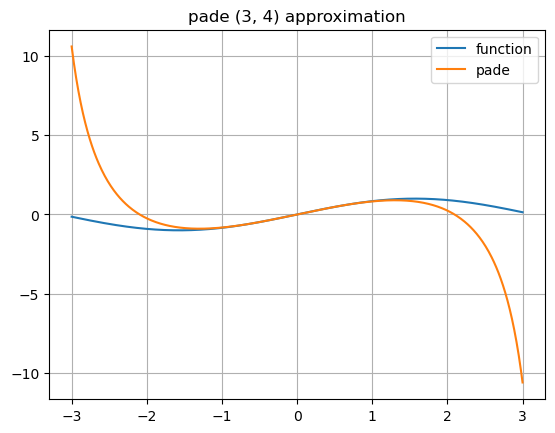

In [10]:
m = 3
n = 4
left = -3
right = 3
print(sin_maclaurin(m + n + 2))
pade_approx(m, n, np.sin, sin_maclaurin(m + n + 2), left, right, True)

[1.000e+00 1.000e+00 5.000e-01 1.667e-01 4.167e-02 8.333e-03 1.389e-03 1.984e-04 2.480e-05 2.756e-06 2.756e-07 2.505e-08 2.088e-09]
c
 [8.333e-03 1.389e-03 1.984e-04 2.480e-05 2.756e-06 2.756e-07]
r
 [0.008 0.042 0.167 0.5   1.    1.   ]
b
 [1.389e-03 1.984e-04 2.480e-05 2.756e-06 2.756e-07 2.505e-08]

matrix
 [[8.333e-03 4.167e-02 1.667e-01 5.000e-01 1.000e+00 1.000e+00]
 [1.389e-03 8.333e-03 4.167e-02 1.667e-01 5.000e-01 1.000e+00]
 [1.984e-04 1.389e-03 8.333e-03 4.167e-02 1.667e-01 5.000e-01]
 [2.480e-05 1.984e-04 1.389e-03 8.333e-03 4.167e-02 1.667e-01]
 [2.756e-06 2.480e-05 1.984e-04 1.389e-03 8.333e-03 4.167e-02]
 [2.756e-07 2.756e-06 2.480e-05 1.984e-04 1.389e-03 8.333e-03]]

q
 [ 5.455e-01 -1.364e-01  2.020e-02 -1.894e-03  1.082e-04 -3.006e-06]
c
 [1.    1.    0.5   0.167 0.042 0.008]
r
 [1. 0. 0. 0. 0. 0.]

mat
 [[1.    0.    0.    0.    0.    0.   ]
 [1.    1.    0.    0.    0.    0.   ]
 [0.5   1.    1.    0.    0.    0.   ]
 [0.167 0.5   1.    1.    0.    0.   ]
 [0.042 0.1

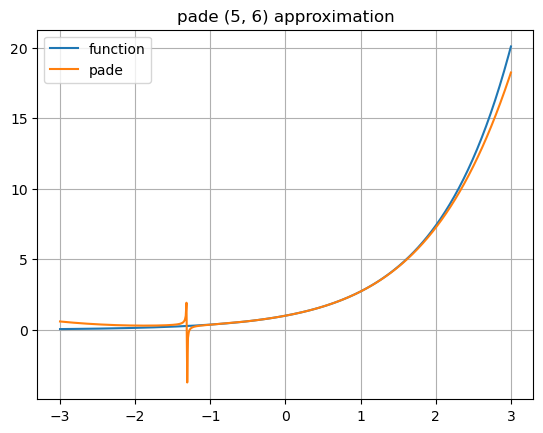

In [161]:
m = 5
n = 6
left = -3
right = 3
print(exp_maclaurin(m + n + 2))
pade_approx(m, n, np.exp, exp_maclaurin(m + n + 2), left, right, True)